In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from pandas.io.json import json_normalize

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.1)

from datetime import datetime

from scipy import stats

from __future__ import division
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import roc_curve


In [2]:
#df_login = json_normalize(data, record_path='login_time', meta='login_time') 
# DO NOT DO THIS!! WILL CRASH YOUR COMPUTER


In [3]:
file=open('logins.json', 'r')

file_content=file.read()

file.close()

data=json.loads(file_content)

df=pd.DataFrame(data, )

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df = df.apply(pd.to_datetime)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.7 KB


In [7]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


## Login Time

When resampling the data in 15 minute intervals, there is a huge spike in March. The login times counts are consistent throughout January and February. However, as the month approaches March the logins increases dramatically in March and starts to be frequent from March to April. But the volumne increase happens in March.


When resampling the data in 24 (daily) interval, the daily volume increases as the month approaches March. However, when looking at the monthly interval, the volume of login counts increases at February and is at the its max in the month of March and decreases sharply as it approaches April. 


In [8]:
ts = pd.Series(list(range(len(df.login_time))), index=df.login_time)

In [9]:
def plot_tsseries(df,interval):
    df.resample(interval).count().plot(figsize=(12,4))
    plt.xlabel('Login Time')
    plt.ylabel('Frequency')

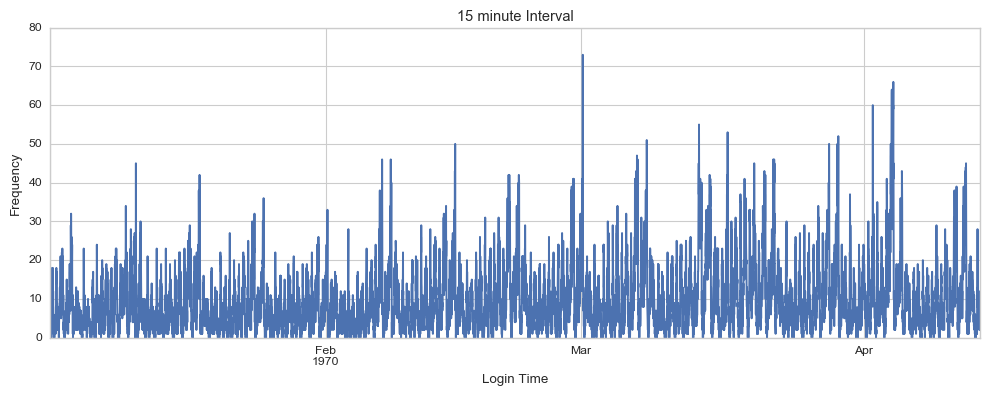

In [10]:
plot_tsseries(ts,'15T')
plt.title('15 minute Interval')

In [11]:
#15 minute intervals for login counts
#df.groupby(['login_time']).size().resample('15T').count().plot(figsize=(12,4))

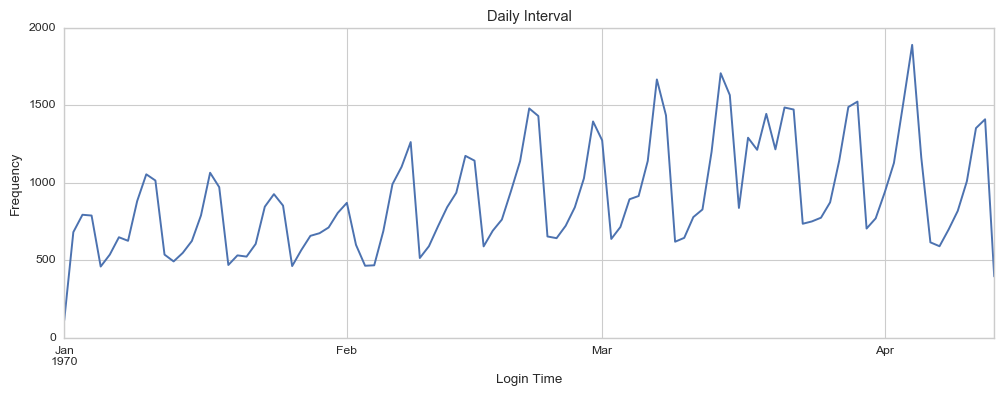

In [12]:
plot_tsseries(ts,'D')
plt.title('Daily Interval')

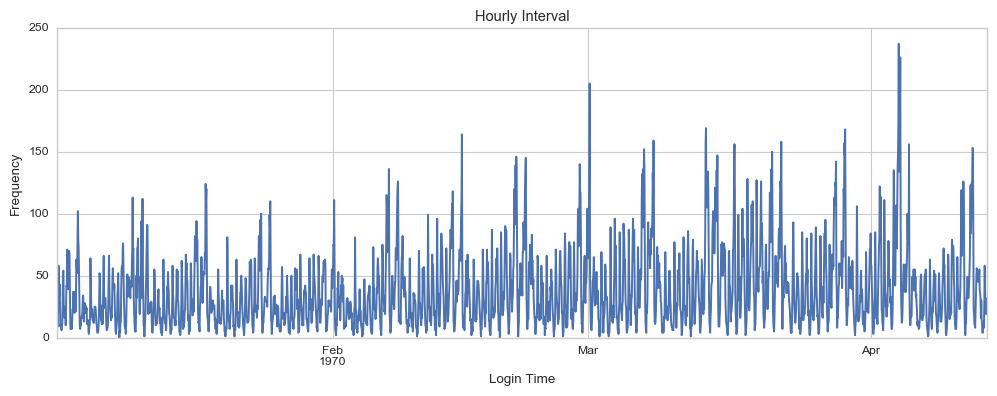

In [13]:
plot_tsseries(ts,'H')
plt.title('Hourly Interval')

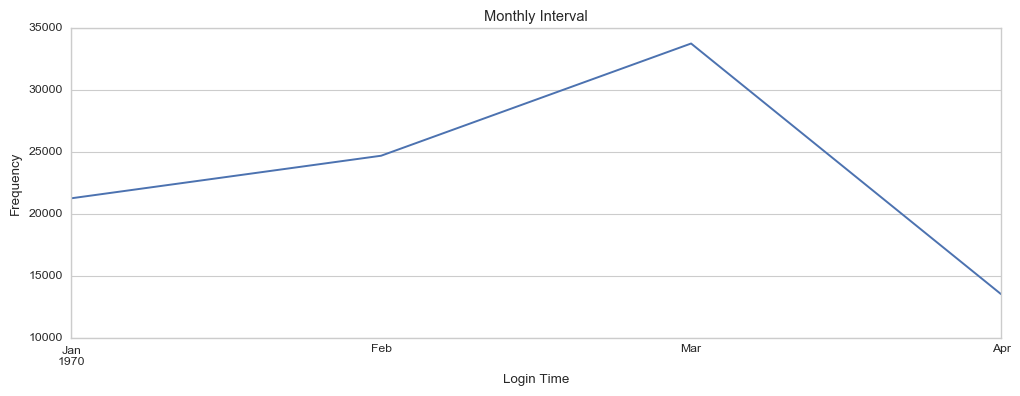

In [14]:
plot_tsseries(ts,'M')
plt.title('Monthly Interval')

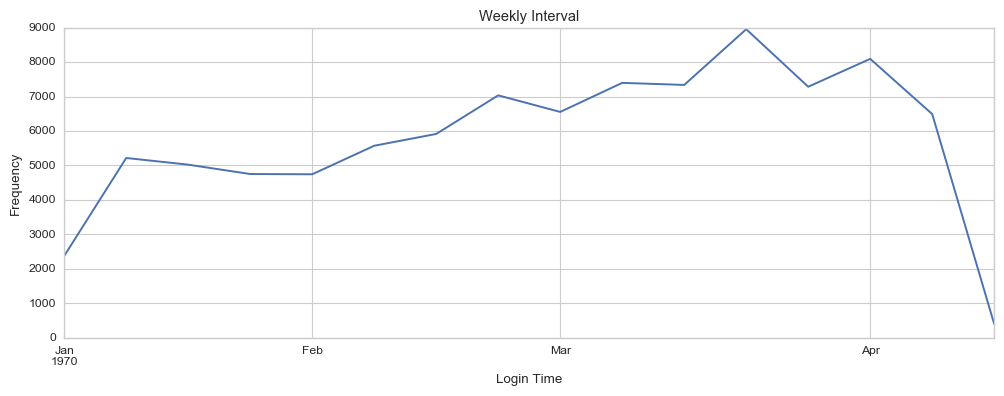

In [15]:
plot_tsseries(ts,'W')
plt.title('Weekly Interval')

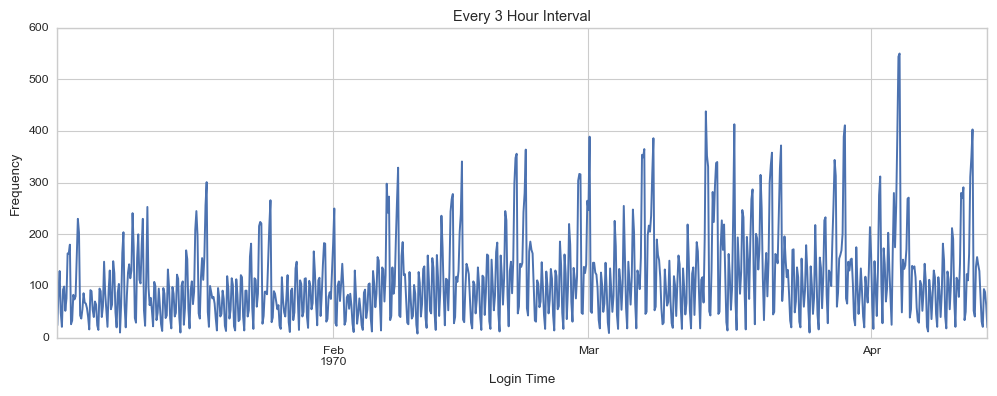

In [16]:
plot_tsseries(ts,'3H')
plt.title('Every 3 Hour Interval')

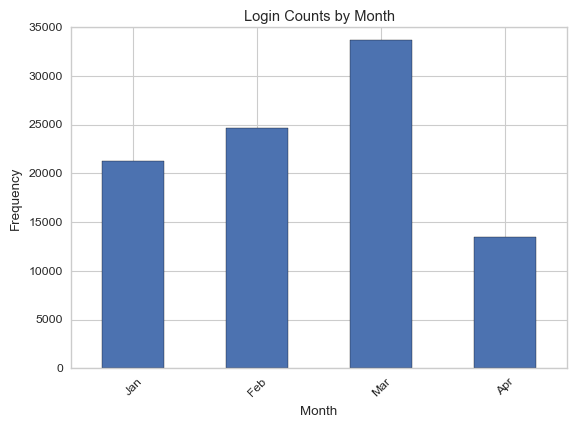

In [17]:
fig, ax = plt.subplots()
df.login_time.dt.month.value_counts().sort_index().plot(kind='bar', ax=ax)


#label =  [item.get_text() for item in ax.get_xticklabels()]
months = ['Jan','Feb','Mar','Apr']

ax.set_xticklabels(months, minor=False, rotation=45)

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Login Counts by Month')

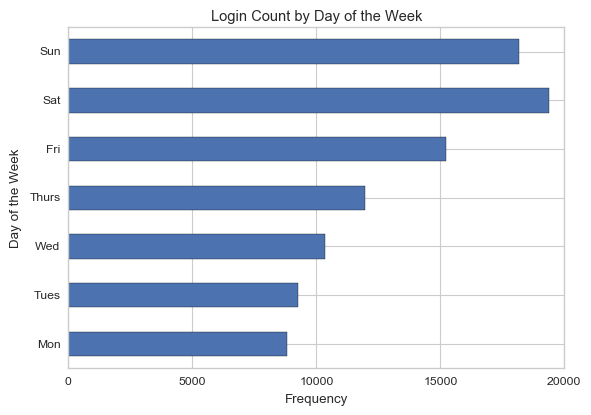

In [18]:
fig, ax = plt.subplots()
df.login_time.dt.dayofweek.value_counts().sort_index().plot(kind='barh', ax=ax)

dayofweek = ['Mon', 'Tues','Wed','Thurs','Fri','Sat','Sun']
ax.set_yticklabels(dayofweek, minor=False)
plt.title('Login Count by Day of the Week')
plt.ylabel('Day of the Week')
plt.xlabel('Frequency')

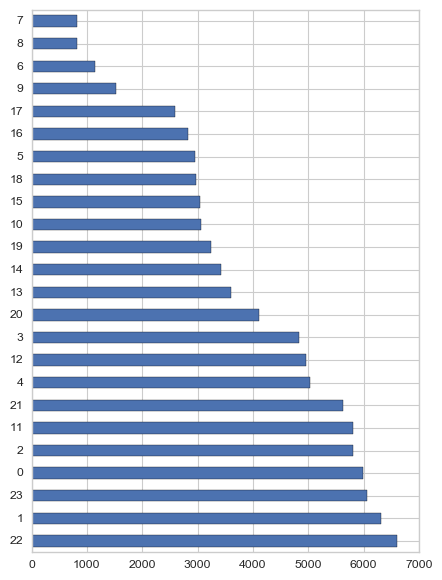

In [19]:
fig, ax = plt.subplots()
df.login_time.dt.hour.value_counts().plot(kind='barh', figsize=(5,7))
time24 = str(np.arange(1,25))


In [20]:
ts.resample('M').count()

login_time
1970-01-31    21239
1970-02-28    24673
1970-03-31    33723
1970-04-30    13507
Freq: M, dtype: int64

In [21]:
stats.norm.sf(abs(-6.9951))

1.3253489787501544e-12

# Experiment

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    
    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats

## Solution

1. A simple success metric would be to compare the frequency of the toll crossings from before the removal of the toll fee and after. If there is an increase to the number of crossings, then it would suggest that the driver partners no longer exclusive to their city. Also, the city can also see if there is an increased number of reimbursements.  
    Initially, I wanted to compare the proportion of login counts before and after the toll removal, but there are some complications to this. If there is an increase in login counts, this increase maybe due to reasons other than the toll removal and therefore cannot differentiate the cause of the increase. 


2. In order to carry out the experiment, the number of toll crossings per hour will be collected and categorized by before or after the toll removal. The test statistics are the proportion of the toll crossings and the average toll crossings per hour before/after the toll removal by using the Two-Proportion Z-test and a Two-Sample T-test. However, one caveat of the tests are determining when is the cut-off time is for collecting the number of toll crossings before the toll removal. 

#### The Two Proportion Z-Test:

$\hat{P_1}$: The proportion of the toll crossings before toll removal
    
$\hat{P_2}$: The proportion of the toll crossings after toll removal 
    
$H_o$: $\hat{P_1}$ = $\hat{P_2}$, there exist no difference between the number of the toll crossings before and after the removal.
    
$H_A$: $\hat{P_1}$ < $\hat{P_2}$, the number of toll crossings increased after the toll removal. 
    
#### Two-Sample T-Test:
    
$\bar{x_1}$: The average number of toll crossings per hour before the toll removal.
    
$\bar{x_2}$: The average number of toll crossings per hour after the toll removal. 
    
$H_o$: $\bar{x_1}$ = $\bar{x_2}$, there exist no difference in the average number of toll crossings per hour before and after the toll removal. 
    
$H_A$: $\bar{x_1}$ < $\bar{x_2}$, the average number of toll crossings per hour increased after the toll removal.

#### Results:
    
  If the p-value is less than 0.05, then for both tests there exist a difference between the number of toll crossings before and after the toll removal. By using a 95% confidence level, we can quantify how much of a difference there is. 
  
  If $\hat{P_1}$ - $\hat{P_2}$ is positive, then the number of toll crossings is higher before the toll removal and therefore driver partners are not crossing driving between the two cities with a preference to stay within their city. 
  
  If $\hat{P_1}$ - $\hat{P_2}$ is negative, then the number of toll crossings is higher after the toll removal and driver partners are driving between the cities. 
 

# Predicitive Analysis

There exist a 69.22% user retention rate overall. The column where if the user had taken a trip within the first 30 days, if there is 1 or more then that user is categorized as a retained user, else not. By further categorizing the user retention by cities, Winterfell has the highest number of user retention followed by Astapor then King’s Landing. iPhone users have a higher number of retained users than Android. 

I believe the Logistic Regression and the Random Forest Classifier model is the best suited for predicting user retention. With a binary outcome of whether the user was active or inactive, the logistic regression model with the various features as coefficients. In order to determine which features are the most important for the logistic regression model, a wrapper method and filtering method was used. Using the Recursive Feature Elimination method with various scoring merics, it appears that Recall and the F1 scoring metric is best suited for 8 optimal features with the highest cross validation scores respectively. In comparison to using the Variance Thresholds, where the higher the variance, the more useful the feature is, therefore resulting in the weekday percentage, average distance, and the average rating of the driver the most important features. 

The Logistic Regression model has a Test accuracy of 71.7%, which means the model can predict user retention 71.7% of the time. Even when a subset of the data that included the important features, the model still has a 72.2% accuracy. This is relatively the same as the Random Forest Classifier model with a 72.2% accuracy. 


In [80]:
file=open('ultimate_data_challenge.json', 'r')

file_content=file.read()

file.close()

data1=json.loads(file_content,)

data=pd.DataFrame(data1, )

In [81]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [82]:
data['signup_date']= pd.to_datetime(data['signup_date'])

In [83]:
data['last_trip_date']= pd.to_datetime(data['last_trip_date'])

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [63]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [339]:
def retained_user(val):
    if val >= 1:
        return 1
    if val ==0 :
        return 0

In [340]:
data['retained'] = data['trips_in_first_30_days'].apply(retained_user)

In [341]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,1


#### There is a 69.22% user retention rate. 

In [342]:
#looking at retained users
data['retained'].value_counts()#[1] / len(data['retained']) * 100

1    34610
0    15390
Name: retained, dtype: int64

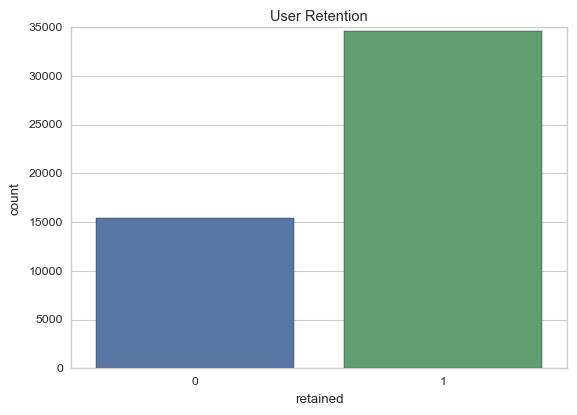

In [156]:
sns.countplot(data['retained'])
plt.title('User Retention')

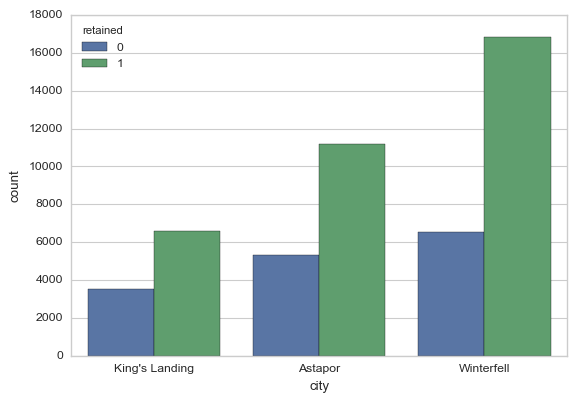

In [183]:
sns.countplot(x=data['city'], hue=data['retained'])

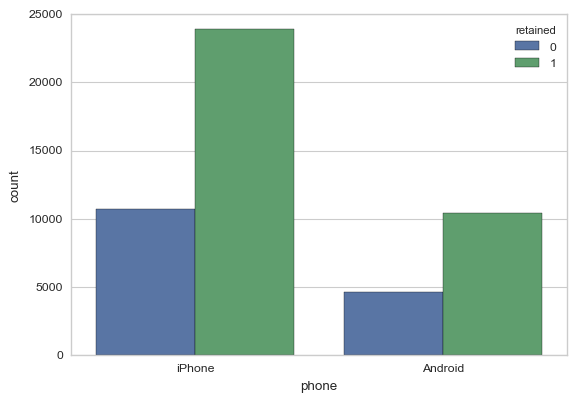

In [184]:
sns.countplot(x=data['phone'], hue=data['retained'])

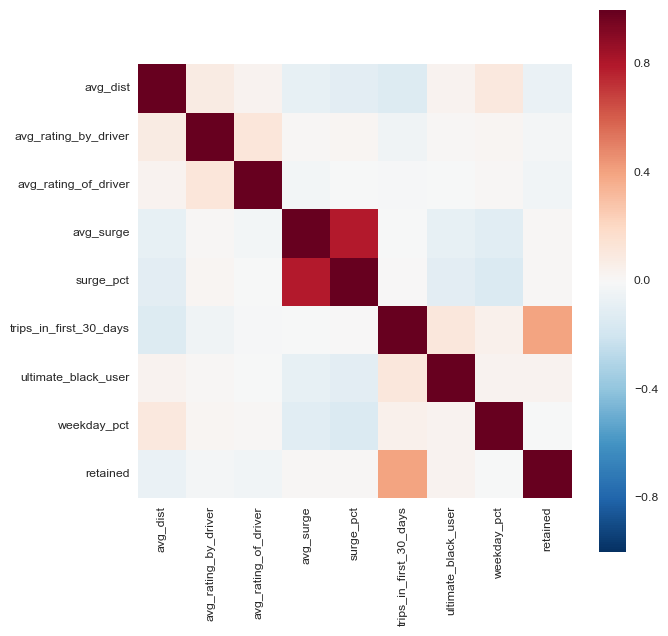

In [88]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data.corr(), square=True, ax=ax)

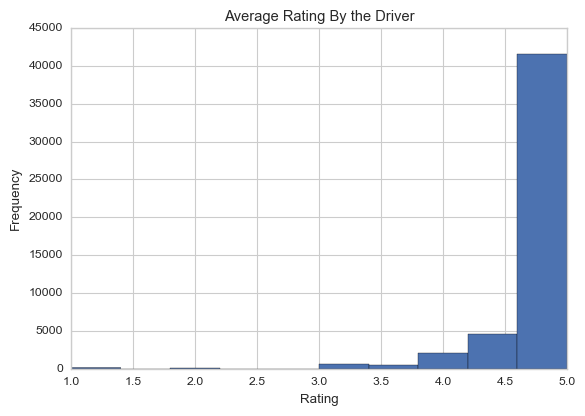

In [413]:
plt.hist(data.avg_rating_by_driver.dropna())
plt.title('Average Rating By the Driver')
plt.xlabel('Rating')
plt.ylabel('Frequency')

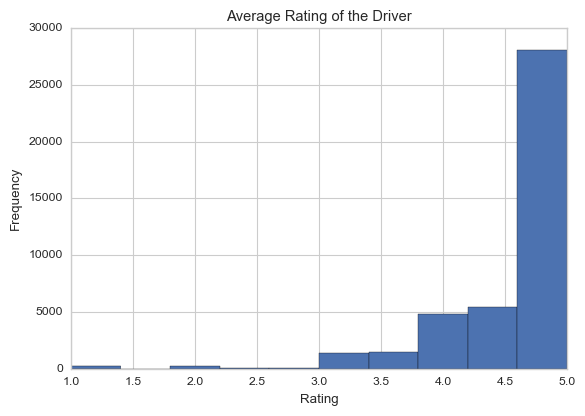

In [412]:
plt.hist(data.avg_rating_of_driver.dropna())
plt.title('Average Rating of the Driver')
plt.xlabel('Rating')
plt.ylabel('Frequency')

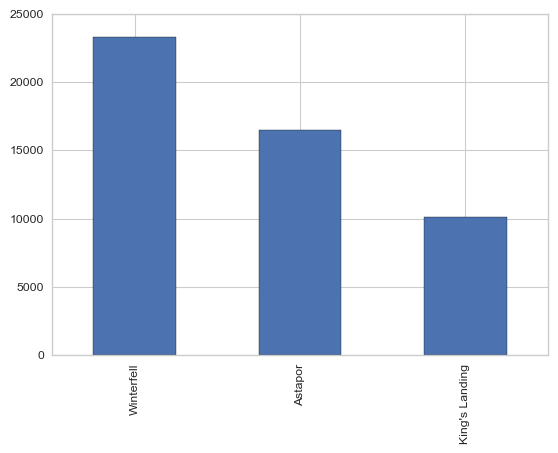

In [89]:
data.city.value_counts().plot(kind='bar')

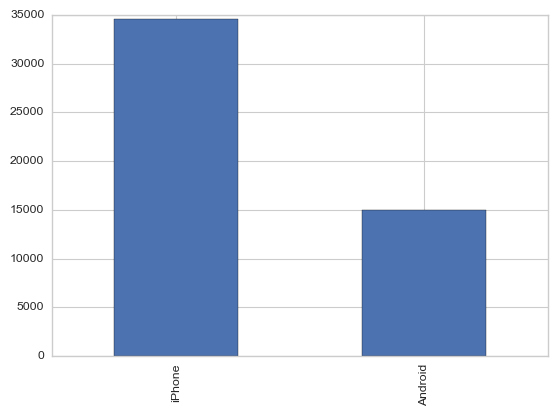

In [71]:
data.phone.value_counts().plot(kind='bar')

In [101]:
def true_false(val):
    if val == True:
        return 1
    else:
        return 0

data['ultimate_black_user'] = data['ultimate_black_user'].apply(true_false)

In [102]:
#creating dummy variables for the categorical data
dummy_cities = pd.get_dummies(data=data['city'])

In [103]:
dummy_phone = pd.get_dummies(data=data['phone'])

In [104]:
df1 = pd.concat([data, dummy_cities, dummy_phone], axis=1)

In [105]:
df1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,Astapor,King's Landing,Winterfell,Android,iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1,0.0,1.0,0.0,0.0,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0,1.0,0.0,0.0,1.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,1,1.0,0.0,0.0,0.0,1.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1,0.0,1.0,0.0,0.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,1,0.0,0.0,1.0,1.0,0.0


In [106]:
#rearranging the column order
cols = df1.columns.tolist()

In [123]:
col = cols[0:4] + cols[9:12] + cols[13:] + cols[12:13]

In [125]:
df1 = df1[col]

In [128]:
df1.isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
Astapor                   False
King's Landing            False
Winterfell                False
Android                   False
iPhone                    False
retained                  False
dtype: bool

In [135]:
df1[df1.avg_rating_by_driver.isnull()==True].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,retained
90,6.28,NaN,5.0,1.0,1,0,0.0,0.0,0.0,1.0,0.0,1.0,1
274,6.00,NaN,2.0,4.0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,1
277,1.82,NaN,NaN,1.0,1,0,0.0,0.0,0.0,1.0,0.0,1.0,1
536,1.41,NaN,5.0,1.0,1,0,100.0,0.0,0.0,1.0,1.0,0.0,1
857,0.42,NaN,4.0,1.0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0


In [188]:
df1.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,retained
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,2.278200,0.37708,60.926084,0.330680,0.202600,0.466720,0.300440,0.691640,0.692200
std,5.707357,0.446652,0.617338,0.222336,3.792684,0.48466,37.081503,0.470463,0.401941,0.498896,0.458454,0.461821,0.461588
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,NaN,NaN,1.000000,0.000000,0.00000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,NaN,NaN,1.000000,1.000000,0.00000,66.700000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,6.940000,NaN,NaN,1.050000,3.000000,1.00000,100.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,125.000000,1.00000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [210]:
df1.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
Astapor                      0
King's Landing               0
Winterfell                   0
Android                      0
iPhone                       0
retained                     0
dtype: int64

In [211]:
df1.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  41744 non-null float64
avg_rating_by_driver      41744 non-null float64
avg_rating_of_driver      41744 non-null float64
avg_surge                 41744 non-null float64
trips_in_first_30_days    41744 non-null int64
ultimate_black_user       41744 non-null int64
weekday_pct               41744 non-null float64
Astapor                   41744 non-null float64
King's Landing            41744 non-null float64
Winterfell                41744 non-null float64
Android                   41744 non-null float64
iPhone                    41744 non-null float64
retained                  41744 non-null int64
dtypes: float64(10), int64(3)
memory usage: 4.5 MB


In [212]:
df1 = df1.dropna()

# Machine Learning

In [352]:
X = df1.drop(['retained','trips_in_first_30_days'], axis=1)
y = df1.retained

# Feature Elimination

In [194]:
def plot_nfeat(model):
    """preforms a recursive feature elimination with cross validation, using 
    whatever scoring you like"""
    score_metric = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
    f, ax = plt.subplots(sharey=True)
    for s in score_metric:
        selector = RFECV(model, step=1, cv=StratifiedKFold(10), scoring=s)
        selector.fit(X,y)                
        print ('Scoring: {}'.format(s))
        print ('Optimal Number of Features = {}'.format(selector.n_features_))
        headers = ['Name', 'Ranking']
        values = sorted(zip(X.columns, selector.ranking_))
        top_feat = filter(lambda x:x[:][1]==1, values)
    
        top_feats = []
        top_feats.append(top_feat)
        unique_feats = np.unique((np.array(top_feats)))
        top_features = unique_feats.tolist()
        print (top_features[1:])
        print ('\t')
        
        
        plt.xlabel('Number of Features Selected')
        plt.ylabel('Cross Validation Score')
        plt.plot(range(1,len(selector.grid_scores_)+1), selector.grid_scores_, label=s)
        plt.title('Optimal Number of Features')
        plt.legend()

Scoring: accuracy
Optimal Number of Features = 8
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user']
	
Scoring: roc_auc
Optimal Number of Features = 10
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user']
	
Scoring: f1
Optimal Number of Features = 8
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user']
	
Scoring: precision
Optimal Number of Features = 10
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user']
	
Scoring: recall
Optimal Number of Features = 8
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user']
	


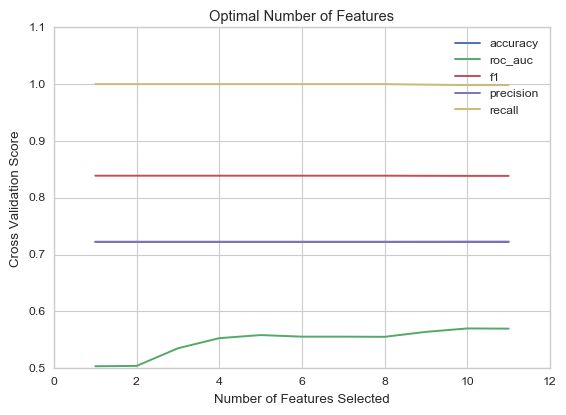

In [353]:
logit = LogisticRegression()
plot_nfeat(logit)

Scoring: accuracy
Optimal Number of Features = 1
[u'avg_dist']
	
Scoring: roc_auc
Optimal Number of Features = 11
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user', u'weekday_pct']
	
Scoring: f1
Optimal Number of Features = 1
[u'avg_dist']
	
Scoring: precision
Optimal Number of Features = 11
[u'Android', u'Astapor', u"King's Landing", u'Winterfell', u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', u'iPhone', u'ultimate_black_user', u'weekday_pct']
	
Scoring: recall
Optimal Number of Features = 1
[u'avg_dist']
	


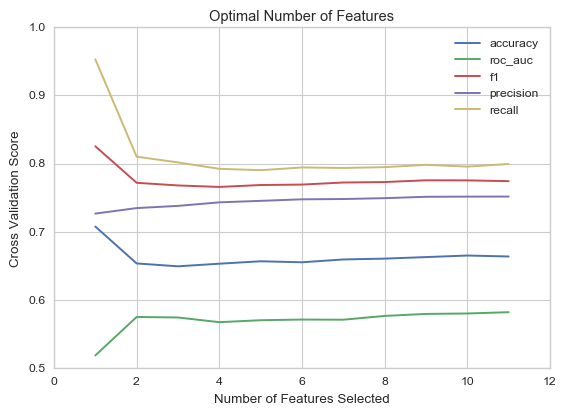

In [355]:
plot_nfeat(RandomForestClassifier())

                         Score
Column                        
avg_dist              0.573502
weekday_pct           0.126690
avg_rating_of_driver  0.083869
avg_rating_by_driver  0.080986
avg_surge             0.076398
ultimate_black_user   0.018391
iPhone                0.009499
Android               0.008662
Winterfell            0.008156
Astapor               0.007081
King's Landing        0.006765


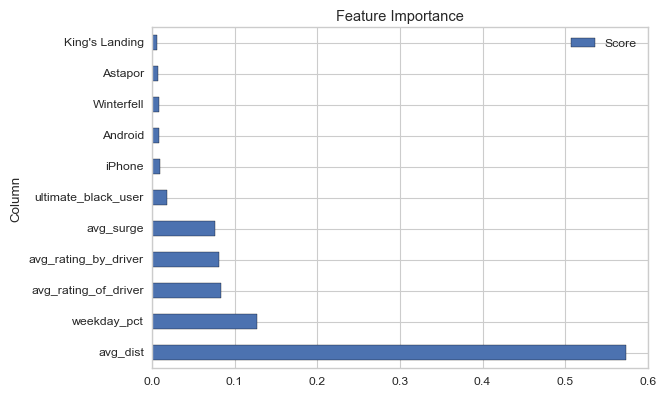

In [356]:
rf = RandomForestClassifier()
rf.fit(X,y)
headers = ['Column', 'Score']
values = sorted(zip(X.columns, rf.feature_importances_), key=lambda x:x[1]*-1)

df_rf = pd.DataFrame(data=values, columns=headers).set_index('Column')

print (df_rf)

df_rf.plot(kind='barh')
plt.title('Feature Importance')

In [357]:
logit = LogisticRegression()
pca = PCA()
pipe = Pipeline([('pca',pca), ('logistic',logit)])

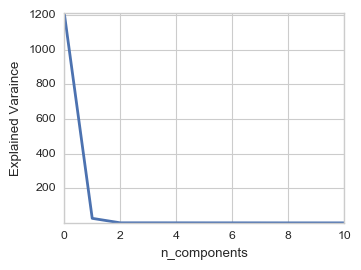

In [358]:
pca.fit(X)
plt.figure(1, figsize=(4,3))
plt.clf()
plt.axes([.2,.2,.7,.7])
plt.plot(pca.explained_variance_,linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Explained Varaince')

In [359]:
features = range(pca.n_components_)

<Container object of 11 artists>

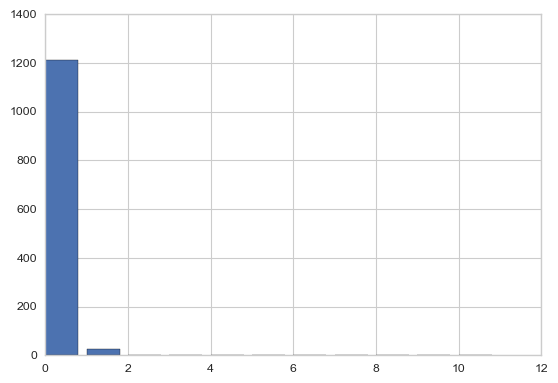

In [360]:
plt.bar(features, pca.explained_variance_)

In [361]:
#Using a filter method with Variance Thresholds
#the higher the variance, the more useful the information is
X.var().sort_values(ascending=False)

weekday_pct             1211.036081
avg_dist                  26.520547
avg_rating_of_driver       0.379553
Winterfell                 0.248615
ultimate_black_user        0.236921
Astapor                    0.219658
iPhone                     0.208738
Android                    0.205776
King's Landing             0.166774
avg_rating_by_driver       0.163304
avg_surge                  0.039474
dtype: float64

In [362]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X,y)
np.set_printoptions(precision=3)

In [363]:
headers = ['Column', 'Score', 'pval']
values = sorted(zip(X.columns, fit.scores_, fit.pvalues_), key=lambda x:x[1]*-1)
df_kbest = pd.DataFrame(data=values, columns=headers).set_index('Column')
print (df_kbest)

                           Score           pval
Column                                         
avg_dist              879.201804  3.259547e-193
Winterfell             82.382217   1.121584e-19
King's Landing         70.994476   3.582265e-17
weekday_pct            65.153385   6.928932e-16
ultimate_black_user    28.954081   7.411451e-08
Astapor                16.223248   5.629897e-05
avg_rating_of_driver    3.468744   6.253880e-02
avg_rating_by_driver    0.605202   4.365999e-01
Android                 0.229720   6.317318e-01
avg_surge               0.175093   6.756244e-01
iPhone                  0.001161   9.728145e-01


# Implementing Logitstic Regression Model

In [397]:
Cs = np.logspace(-4,4,10)
logit_params = {'C': Cs}

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)
model_cv = GridSearchCV(LogisticRegression(), param_grid=logit_params, cv=StratifiedKFold(10))
model_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [399]:
model_cv.best_params_

{'C': 0.0001}

In [400]:
y_pred = model_cv.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.00      0.00      3535
          1       0.72      1.00      0.84      8989

avg / total       0.80      0.72      0.60     12524



In [401]:
print (confusion_matrix(y_test,y_pred))


(array([[   3, 3532],
       [   0, 8989]]),)


In [402]:
cross_val_score(LogisticRegression(),X,y, cv=StratifiedKFold(10)).mean()

0.7222115800379764

In [403]:
print ('Training Score:{}'.format(model_cv.best_score_))
print('Test Data Score: {}'.format(model_cv.score(X_test, y_test)))

Training Score:0.724229979466
Test Data Score: 0.717981475567


In [404]:
best_model = model_cv.best_estimator_

print('Sanity Check: {}'.format(best_model.fit(X_train, y_train).score(X_test, y_test)))

Sanity Check: 0.717981475567


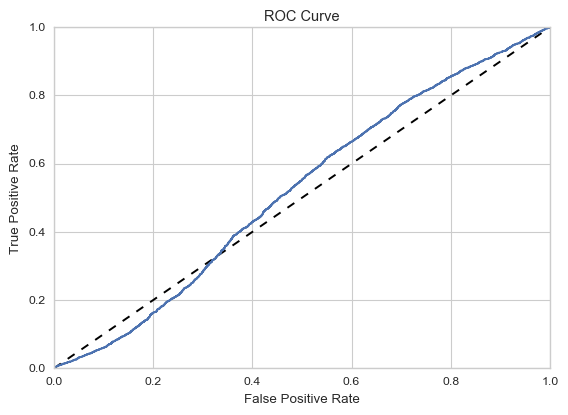

In [405]:
y_pred_prob = model_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Training Score:0.722518822724
Test Data Score: 0.722053656979
Sanity Check: 0.722053656979
             precision    recall  f1-score   support

          0       0.50      0.00      0.00      3481
          1       0.72      1.00      0.84      9043

avg / total       0.66      0.72      0.61     12524

[[   1 3480]
 [   1 9042]]


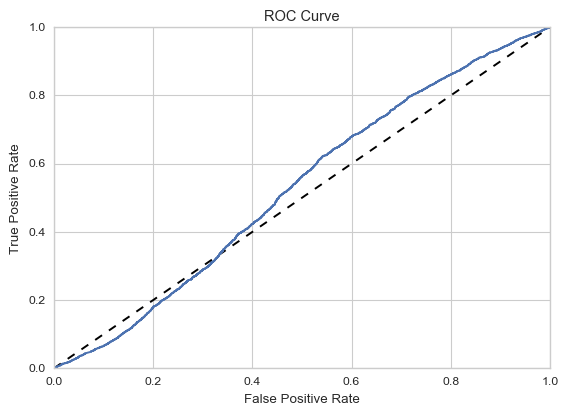

In [411]:
#using the important features

X1 =df1[['Android', 'Astapor', "King's Landing", 'Winterfell', 'avg_rating_of_driver', 'avg_surge', 'iPhone', 'ultimate_black_user']]
y = df1.retained

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)
model_cv = GridSearchCV(LogisticRegression(), param_grid=logit_params, cv=StratifiedKFold(10))
model_cv.fit(X_train,y_train)


print ('Training Score:{}'.format(model_cv.best_score_))
print('Test Data Score: {}'.format(model_cv.score(X_test, y_test)))

best_model = model_cv.best_estimator_
print('Sanity Check: {}'.format(best_model.fit(X_train, y_train).score(X_test, y_test)))


y_pred = model_cv.predict(X_test)
print(classification_report(y_test, y_pred))
print (confusion_matrix(y_test,y_pred))
y_pred_prob = model_cv.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30 )

RF_params = {"max_depth": [3, 6, 9, None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
n_iter_search = 20

model_rv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=RF_params,
                             cv=StratifiedKFold(10))
model_rv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'min_samples_split': [2, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 6, 9, None], 'min_samples_leaf': [1, 3, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [389]:
model_rv.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [392]:
print ('Training Score:{}'.format(model_rv.best_score_))
print('Test Data Score: {}'.format(model_rv.score(X_test, y_test)))

Training Score:0.722210814511
Test Data Score: 0.723650590866


In [393]:
best_model = model_rv.best_estimator_

print('Sanity Check: {}'.format(best_model.fit(X_train, y_train).score(X_test, y_test)))

Sanity Check: 0.722931970616


In [390]:
y_pred = model_rv.predict(X_test)
print(classification_report(y_test, y_pred))
print (confusion_matrix(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.58      0.01      0.01      3466
          1       0.72      1.00      0.84      9058

avg / total       0.68      0.72      0.61     12524

[[  19 3447]
 [  14 9044]]
